In [1]:
def div(x,y):
    return x/y if y else 0

In [2]:
%pip install pytorch-fid

Note: you may need to restart the kernel to use updated packages.


In [3]:
from os import listdir
from os.path import isfile, join
import torch
from torch.utils.data import Subset
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models
import segmentation_models_pytorch
import pretrainedmodels
import pytorch_ssim
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import PIL 
import numpy as np
from sklearn.model_selection import train_test_split
from pytorch_fid import inception
from scipy import linalg

c:\Users\malco\anaconda3\envs\4107\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
MRI_FOLDER = "D:/MRI_slices"
CT_FOLDER = "D:/CT_slices"
IMAGE_SHAPE = (256, 256)

# CT and MRI Datasets

In [5]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, path):
    super(Dataset, self).__init__()
    self.transform = transforms.Compose([transforms.ToTensor()])
    self.path = path
    self.items = [f for f in listdir(path) if isfile(join(path, f))]
  
  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    img = PIL.Image.open(f'{self.path}/{self.items[idx]}')
    img = img.convert('L')
    return self.transform(img.resize(IMAGE_SHAPE))

In [6]:
MRIDataset = Dataset(MRI_FOLDER)
CTDataset = Dataset(CT_FOLDER)
MRIDataset = Subset(MRIDataset, range(35))
CTDataset = Subset(CTDataset, range(35))

MRI_train_id, MRI_test = train_test_split(range(len(MRIDataset)), test_size=0.2)
CT_train_id, CT_test = train_test_split(range(len(CTDataset)), test_size=0.2)

MRIDataset_train = torch.utils.data.Subset(MRIDataset, MRI_train_id)
MRIDataset_test = torch.utils.data.Subset(MRIDataset, MRI_test)
CTDataset_train = torch.utils.data.Subset(CTDataset, CT_train_id)
CTDataset_test = torch.utils.data.Subset(CTDataset, CT_test)

# Generator

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect")
        self.norm1 = nn.InstanceNorm2d(channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect")
        self.norm2 = nn.InstanceNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.relu1(self.norm1(self.conv1(x)))
        out = self.norm2(self.conv2(out))
        out = identity + out
        return out


class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down1 = nn.Sequential(
            nn.Conv2d(num_features, num_features*2, kernel_size=3, stride=2, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features*2),
            nn.ReLU(inplace=True),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features*4),
            nn.ReLU(inplace=True),
        )
        self.residuals = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(num_features*4, num_features*2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(num_features*2),
            nn.ReLU(inplace=True),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(num_features*2, num_features*1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(num_features*1),
            nn.ReLU(inplace=True),
        )
        self.last = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.residuals(x)
        x = self.up1(x)
        x = self.up2(x)
        x = nn.Tanh(self.last(x))
        return x

# Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        feature,
                        4,
                        stride=2,
                        padding=1,
                        padding_mode="reflect"
                    ),
                    nn.InstanceNorm2d(feature),
                    nn.LeakyReLU(0.2, inplace=True),
                )
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return nn.sigmoid(self.model(x))

# ResNet Generator

In [9]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.model = segmentation_models_pytorch.Unet('resnet18', encoder_weights = 'imagenet', decoder_use_batchnorm = True, activation = nn.ReLU, in_channels=1)
    
  def forward(self, x):
    x = self.model(x)
    return x

# ResNet Discriminator

In [10]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.layer = nn.Conv2d(1, 3, (2, 2), padding=2)
    model = pretrainedmodels.resnet18(pretrained = 'imagenet')
    model.last_linear = nn.Linear(in_features=512, out_features=1, bias=True)
    self.model = model

  def forward(self, x):
    x = self.layer(x)
    x = self.model(x)
    return x

In [11]:
class CycleGAN(nn.Module):
    def __init__(self, generator_B, generator_A, discriminator_A, discriminator_B):
        super(CycleGAN, self).__init__()
        self.generator_A = generator_A
        self.generator_B = generator_B
        self.discriminator_A = discriminator_A
        self.discriminator_B = discriminator_B

    def forward(self, real_A, real_B):
        fake_B = self.generator_B(real_A)
        reconstructed_A = self.generator_A(fake_B)
        real_B_disc = self.discriminator_B(real_B)
        fake_B_disc = self.discriminator_B(fake_B)
        
        fake_A = self.generator_A(real_B)
        reconstructed_B = self.generator_B(fake_A)
        real_A_disc = self.discriminator_A(real_A)
        fake_A_disc = self.discriminator_A(fake_A)
        
        identity_B = self.generator_B(real_B)
        identity_A = self.generator_A(real_A)

        return fake_B_disc, reconstructed_A, real_B_disc, fake_B_disc, fake_A_disc, reconstructed_B, real_A_disc, fake_A_disc, identity_B, identity_A

# Create CycleGAN and optimizer instances

In [12]:
NUM_EPOCHS = 10
BATCH_SIZE = 2
DEVICE = torch.device('cuda')

In [27]:
model = CycleGAN(Generator().to(DEVICE), Generator().to(DEVICE), Discriminator().to(DEVICE), Discriminator().to(DEVICE))

CT_gen_opt = torch.optim.Adam(model.generator_AB.parameters(), lr=1e-3)
MRI_gen_opt = torch.optim.Adam(model.generator_BA.parameters(), lr=1e-3)
CT_disc_opt = torch.optim.Adam(model.discriminator_B.parameters(), lr=1e-3)
MRI_disc_opt = torch.optim.Adam(model.discriminator_A.parameters(), lr=1e-3)

# Training function

In [14]:
def train(model, CT_gen_opt, CT_disc_opt, MRI_gen_opt, MRI_disc_opt, loss_discriminator, loss_cycle, loss_perceptual,
                    MRI_dataset_train, CT_dataset_train, MRI_dataset_test, CT_dataset_test, 
                    batchsize, num_epochs, disc_ratio, gen_ratio, lambda_cycle, lambda_identity):

    MRI_loader = torch.utils.data.DataLoader(MRI_dataset_train, batch_size=batchsize, shuffle=True)
    CT_loader = torch.utils.data.DataLoader(CT_dataset_train, batch_size=int(np.floor(batchsize * len(CT_dataset_train) / len(MRI_dataset_train))), shuffle=True)

    losses_epoch = []

    for epoch in range(num_epochs):
        # clear loss values between epochs
        losses_gen_MRI = losses_disc_CT = losses_gen_CT = losses_disc_MRI = losses_cyc_MRI = losses_cyc_CT = losses_idt_MRI = losses_idt_CT = batches_CT_disc = batches_MRI_disc = batches_CT_gen = batches_MRI_gen = 0
        losses = []

        for i, (real_MRI, real_CT) in enumerate(tqdm(zip(MRI_loader, CT_loader), f'Epoch {epoch}', total=min(len(MRI_loader), len(CT_loader)))):
            training_gen = i % gen_ratio == 0
            training_disc = i % disc_ratio == 0
            model.train()

            #reset losses between batches
            CT_disc_loss = MRI_disc_loss = MRI_cycle_consistency_loss = CT_disc_loss = CT_cycle_consistency_loss = MRI_disc_loss = CT_identity_loss = MRI_identity_loss = 0
            
            real_MRI = real_MRI.to(DEVICE).float()
            real_CT = real_CT.to(DEVICE).float()

            # forward pass
            fake_CT_gen, reconstructed_MRI, real_CT_disc, fake_CT_disc, fake_MRI_gen, reconstructed_CT, real_MRI_disc, fake_MRI_disc, idt_CT, idt_MRI = model(real_MRI, real_CT)

            # backward pass
            if training_gen:
                batches_CT_gen += 1
                MRI_cycle_consistency_loss = lambda_cycle * loss_cycle(real_MRI, reconstructed_MRI)
                MRI_identity_loss = lambda_identity * loss_cycle(real_MRI, idt_MRI)
                CT_disc_loss = loss_discriminator(fake_CT_gen, torch.ones(fake_CT_gen.shape).to(DEVICE)) + loss_perceptual(real_MRI, reconstructed_MRI, real_CT, reconstructed_CT)
                
                losses_gen_CT += CT_disc_loss.item()
                losses_cyc_MRI += MRI_cycle_consistency_loss.item()
                losses_idt_MRI += MRI_identity_loss.item()

            if training_disc:
                batches_CT_disc += 1
                CT_disc_loss = (loss_discriminator(real_CT_disc, torch.ones(real_CT_disc.shape).to(DEVICE)) + loss_discriminator(fake_CT_disc, torch.zeros(fake_CT_disc.shape).to(DEVICE))) / 2
                losses_disc_CT += CT_disc_loss.item()
                
            if training_gen:
                batches_MRI_gen += 1
                CT_cycle_consistency_loss = lambda_cycle * loss_cycle(real_CT, reconstructed_CT)
                CT_identity_loss = lambda_identity * loss_cycle(real_CT, idt_CT)
                MRI_disc_loss = loss_discriminator(fake_MRI_gen, torch.ones(fake_MRI_gen.shape).to(DEVICE)) + loss_perceptual(real_MRI, reconstructed_MRI, real_CT, reconstructed_CT)
                
                losses_gen_MRI += MRI_disc_loss.item()
                losses_cyc_CT += CT_cycle_consistency_loss.item()
                losses_idt_CT += CT_identity_loss.item()
                
            if training_disc:
                batches_MRI_disc += 1
                MRI_disc_loss = (loss_discriminator(real_MRI_disc, torch.ones(real_MRI_disc.shape).to(DEVICE)) + loss_discriminator(fake_MRI_disc, torch.zeros(fake_MRI_disc.shape).to(DEVICE))) / 2
                losses_disc_MRI += MRI_disc_loss.item()
                
            # gradient update
            CT_gen_opt.zero_grad()
            generator_CT_global_loss = MRI_cycle_consistency_loss + MRI_identity_loss + CT_disc_loss
            if not type(generator_CT_global_loss) == int:
                generator_CT_global_loss.backward(retain_graph=True)
                CT_gen_opt.step()

            MRI_gen_opt.zero_grad()
            generator_MRI_global_loss = CT_cycle_consistency_loss + CT_identity_loss + MRI_disc_loss
            if not type(generator_MRI_global_loss) == int:
                generator_MRI_global_loss.backward(retain_graph=True)
                MRI_gen_opt.step()

            CT_disc_opt.zero_grad()
            discriminator_CT_global_loss = 1 * CT_disc_loss
            if not type(discriminator_CT_global_loss) == int:
                discriminator_CT_global_loss.backward()
                CT_disc_opt.step()

            MRI_disc_opt.zero_grad()
            discriminator_MRI_global_loss = 1 * MRI_disc_loss
            if not type(discriminator_MRI_global_loss) == int:
                discriminator_MRI_global_loss.backward()
                MRI_disc_opt.step()

            losses.append((div(losses_gen_CT, batches_CT_gen), 
                        div(losses_disc_CT, batches_CT_disc), 
                        div(losses_gen_MRI, batches_MRI_gen), 
                        div(losses_disc_MRI, batches_MRI_disc), 
                        div(losses_cyc_MRI, batches_CT_gen), 
                        div(losses_cyc_CT, batches_MRI_gen),
                        div(losses_idt_MRI, batches_CT_gen),
                        div(losses_idt_CT, batches_MRI_gen)))
        losses_epoch.append((div(losses_gen_CT, batches_CT_gen), 
                    div(losses_disc_CT, batches_CT_disc), 
                    div(losses_gen_MRI, batches_MRI_gen), 
                    div(losses_disc_MRI, batches_MRI_disc), 
                    div(losses_cyc_MRI, batches_CT_gen), 
                    div(losses_cyc_CT, batches_MRI_gen),
                    div(losses_idt_MRI, batches_CT_gen),
                    div(losses_idt_CT, batches_MRI_gen)))

        if epoch % 5 == 0:
            plot(model, MRI_dataset_test, CT_dataset_test, losses)
            try:
                torch.save(model.state_dict(), f'checkpoints/epoch_{epoch}.pth.tar')
            except:
                pass
    return losses_epoch

def plot(model, MRI_dataset, CT_dataset, losses):
    random_index_ct_1 = random.randint(0, len(CT_dataset) - 1)
    random_index_ct_2 = random.randint(0, len(CT_dataset) - 1)
    random_index_MRI_1 = random.randint(0, len(MRI_dataset) - 1)
    random_index_MRI_2 = random.randint(0, len(MRI_dataset) - 1)

    with torch.no_grad():
        fake_CT_1 = model.generator_AB((MRI_dataset[random_index_MRI_1]).clone().detach().unsqueeze(0).float().to(DEVICE))
        reconstructed_MRI_1 = model.generator_BA(fake_CT_1).unsqueeze(0).float().to(DEVICE)
        fake_CT_2 = model.generator_AB((MRI_dataset[random_index_MRI_2]).clone().detach().unsqueeze(0).float().to(DEVICE))
        reconstructed_MRI_2 = model.generator_BA(fake_CT_2).unsqueeze(0).float().to(DEVICE)


        fake_MRI_1 = model.generator_BA((CT_dataset[random_index_ct_1]).clone().detach().unsqueeze(0).float().to(DEVICE))
        reconstructed_CT_1 = model.generator_AB(fake_MRI_1).unsqueeze(0).float().to(DEVICE)
        fake_MRI_2 = model.generator_BA((CT_dataset[random_index_ct_2]).clone().detach().unsqueeze(0).float().to(DEVICE))
        reconstructed_CT_2 = model.generator_AB(fake_MRI_2).unsqueeze(0).float().to(DEVICE)
    
    plt.figure()
    _, ax = plt.subplots(2,6, figsize=(20, 10))
    ax[0][0].axis('off')
    ax[0][1].axis('off')
    ax[0][2].axis('off')
    ax[0][3].axis('off')
    ax[0][4].axis('off')
    ax[0][5].axis('off')
    ax[0][0].imshow(MRI_dataset[random_index_MRI_1].squeeze().numpy(), cmap='gray')
    ax[0][1].imshow(fake_CT_1.squeeze().cpu().numpy(), cmap='gray')
    ax[0][2].imshow(reconstructed_MRI_1.squeeze().cpu().numpy(), cmap='gray')
    ax[0][3].imshow(MRI_dataset[random_index_MRI_2].squeeze().numpy(), cmap='gray')
    ax[0][4].imshow(fake_CT_2.squeeze().cpu().numpy(), cmap='gray')
    ax[0][5].imshow(reconstructed_MRI_2.squeeze().cpu().numpy(), cmap='gray')
    
    ax[1][0].axis('off')
    ax[1][1].axis('off')
    ax[1][2].axis('off')
    ax[1][3].axis('off')
    ax[1][4].axis('off')
    ax[1][5].axis('off')
    ax[1][0].imshow(CT_dataset[random_index_ct_1].squeeze().numpy(), cmap='gray')
    ax[1][1].imshow(fake_MRI_1.squeeze().cpu().numpy(), cmap='gray')
    ax[1][2].imshow(reconstructed_CT_1.squeeze().cpu().numpy(), cmap='gray')
    ax[1][3].imshow(CT_dataset[random_index_ct_2].squeeze().numpy(), cmap='gray')
    ax[1][4].imshow(fake_MRI_2.squeeze().cpu().numpy(), cmap='gray')
    ax[1][5].imshow(reconstructed_CT_2.squeeze().cpu().numpy(), cmap='gray')

    _ = plt.show()
    CT_Gens = [loss[0] for loss in losses]
    CT_Discs = [loss[1] for loss in losses]
    MRI_Gens = [loss[2] for loss in losses]
    MRI_Discs = [loss[3] for loss in losses]
    MRI_Cycles = [loss[4] for loss in losses]
    CT_Cycles = [loss[5] for loss in losses]
    MRI_Identity = [loss[6] for loss in losses]
    CT_Identity = [loss[7] for loss in losses]

    plt.plot(CT_Gens, label='CT Generator Loss')
    plt.plot(MRI_Gens, label='MRI Generator Loss')
    plt.legend()
    plt.xlabel('Batch')
    plt.ylabel('Generator Loss')
    plt.show()

    plt.plot(CT_Discs, label='CT Discriminator Loss')
    plt.plot(MRI_Discs, label='MRI Discriminator Loss')
    plt.legend()
    plt.xlabel('Batch')
    plt.ylabel('Discriminator Loss')
    plt.show()

    plt.plot(MRI_Cycles, label='MRI Cycle Loss')
    plt.plot(CT_Cycles, label='CT Cycle Loss')
    plt.legend()
    plt.xlabel('Batch')
    plt.ylabel('Cycle Loss')
    plt.show()

    plt.plot(MRI_Identity, label='MRI Identity Loss')
    plt.plot(CT_Identity, label='CT Identity Loss')
    plt.legend()
    plt.xlabel('Batch')
    plt.ylabel('Cycle Loss')
    plt.show()

In [15]:
vgg19 = torchvision.models.vgg19(pretrained = True)

first_features = nn.Sequential(*list(vgg19.children())[0][:6]).cuda()
second_features = nn.Sequential(*list(vgg19.children())[0][:15]).cuda()
third_features = nn.Sequential(*list(vgg19.children())[0][:26]).cuda()
first_features.eval()
second_features.eval()
third_features.eval()
first_features.requires_grad_(False)
second_features.requires_grad_(False)
third_features.requires_grad_(False)

feature_extractors = [first_features, second_features, third_features]
feature_weights = [0.5, 0.5, 0.5]

c:\Users\malco\anaconda3\envs\4107\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def loss_perceptual(MRI, MRI_reconstructed, CT, CT_reconstructed):
    MRI = torch.cat((MRI, MRI, MRI), 1).cuda()
    MRI_reconstructed = torch.cat((MRI_reconstructed, MRI_reconstructed, MRI_reconstructed), 1).cuda()
    CT = torch.cat((CT, CT, CT), 1).cuda()
    CT_reconstructed = torch.cat((CT_reconstructed, CT_reconstructed, CT_reconstructed), 1).cuda()
    loss = torch.zeros((1, 1)).cuda()
    for extractor, weight in zip(feature_extractors, feature_weights):
        loss += weight * (torch.mean(torch.abs(extractor(MRI) - extractor(MRI_reconstructed)))
                          + torch.mean(torch.abs(extractor(CT) - extractor(CT_reconstructed))))
    return loss.cuda()

In [17]:
loss_discriminator = nn.BCEWithLogitsLoss()
loss_cycle = lambda x, y : pytorch_ssim.SSIM()(x, y)
LAMBDA_CYCLE = 10
LAMBDA_IDENTITY = 5

Epoch 0: 100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


<Figure size 640x480 with 0 Axes>

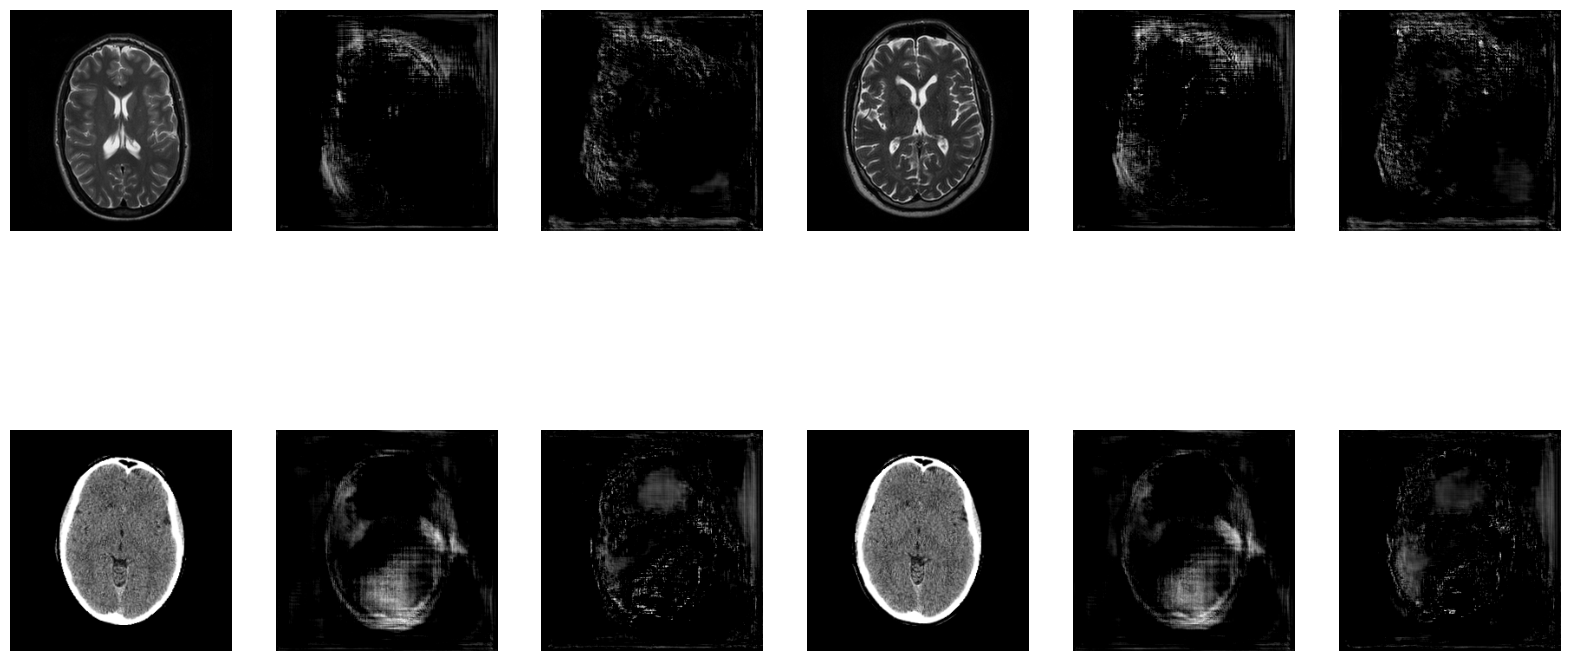

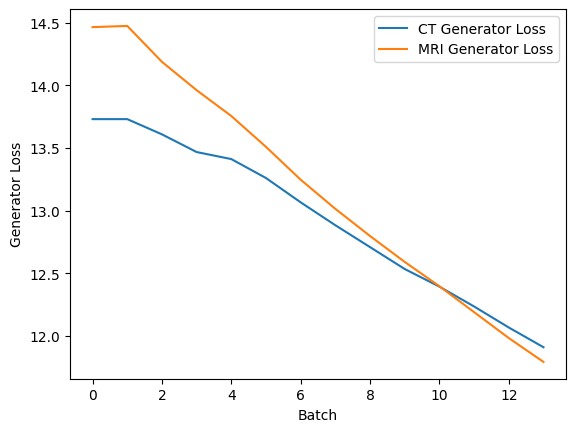

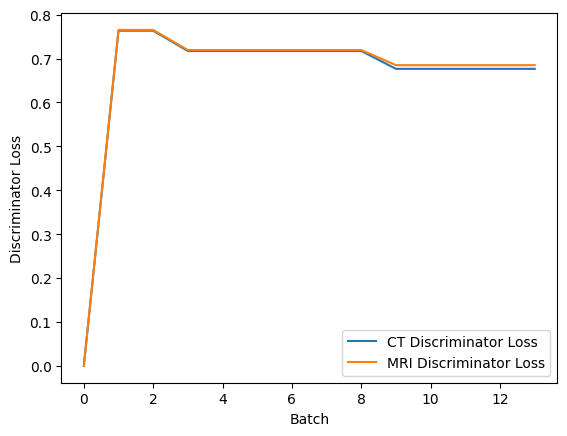

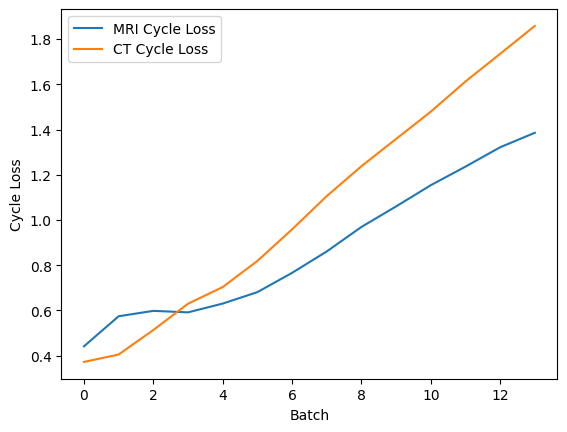

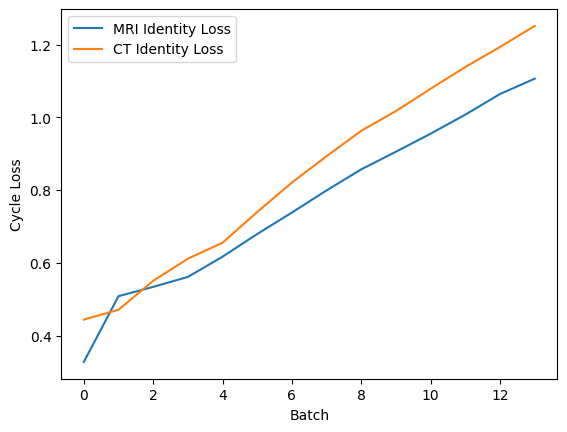

Epoch 2: 100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


<Figure size 640x480 with 0 Axes>

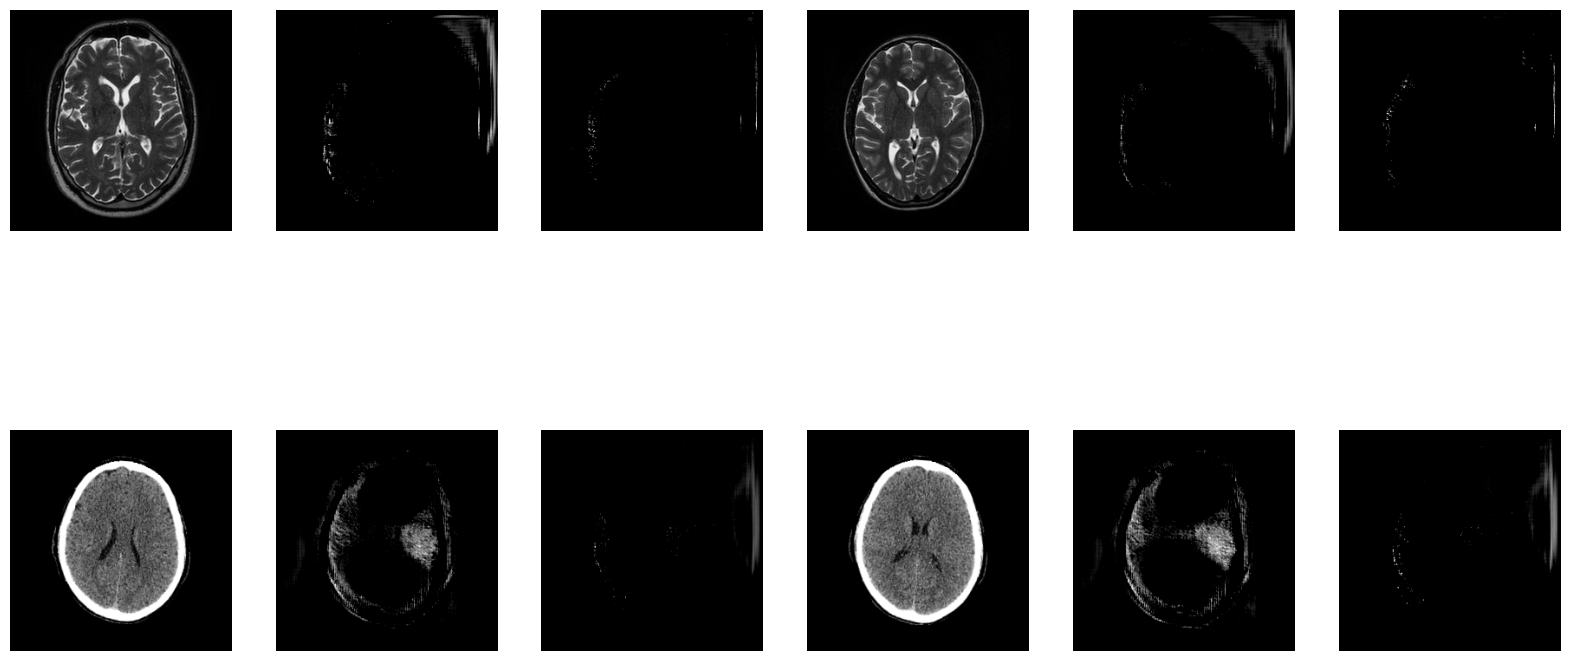

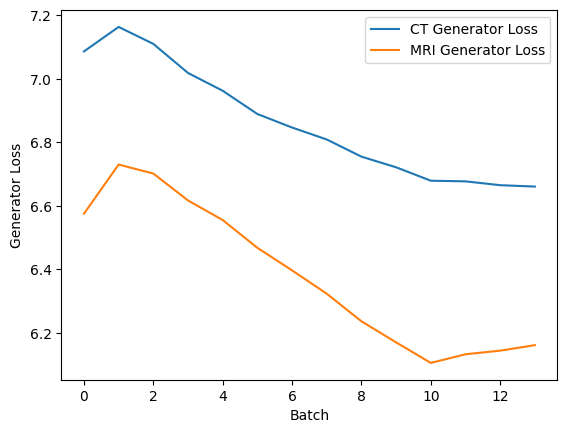

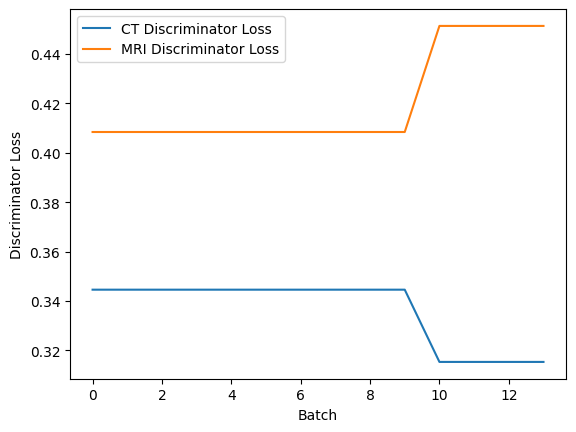

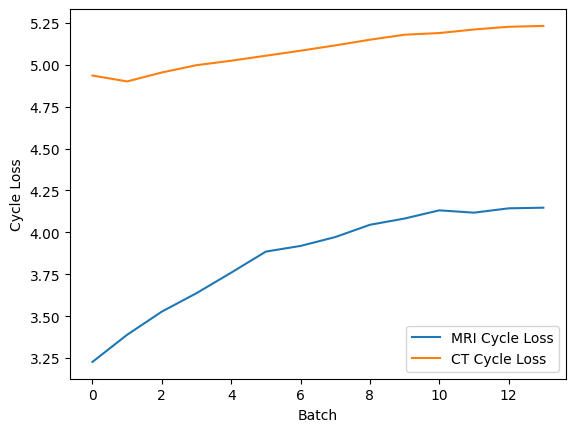

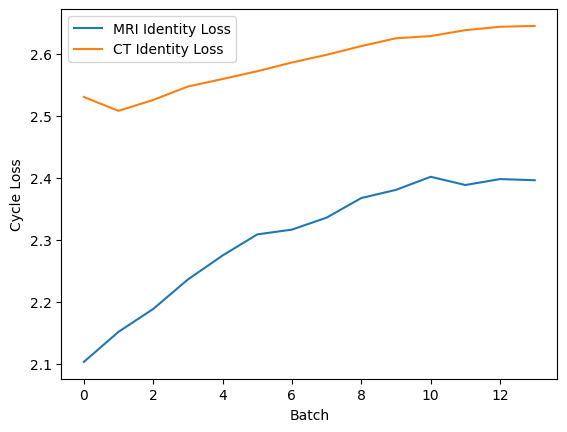

Epoch 4: 100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


<Figure size 640x480 with 0 Axes>

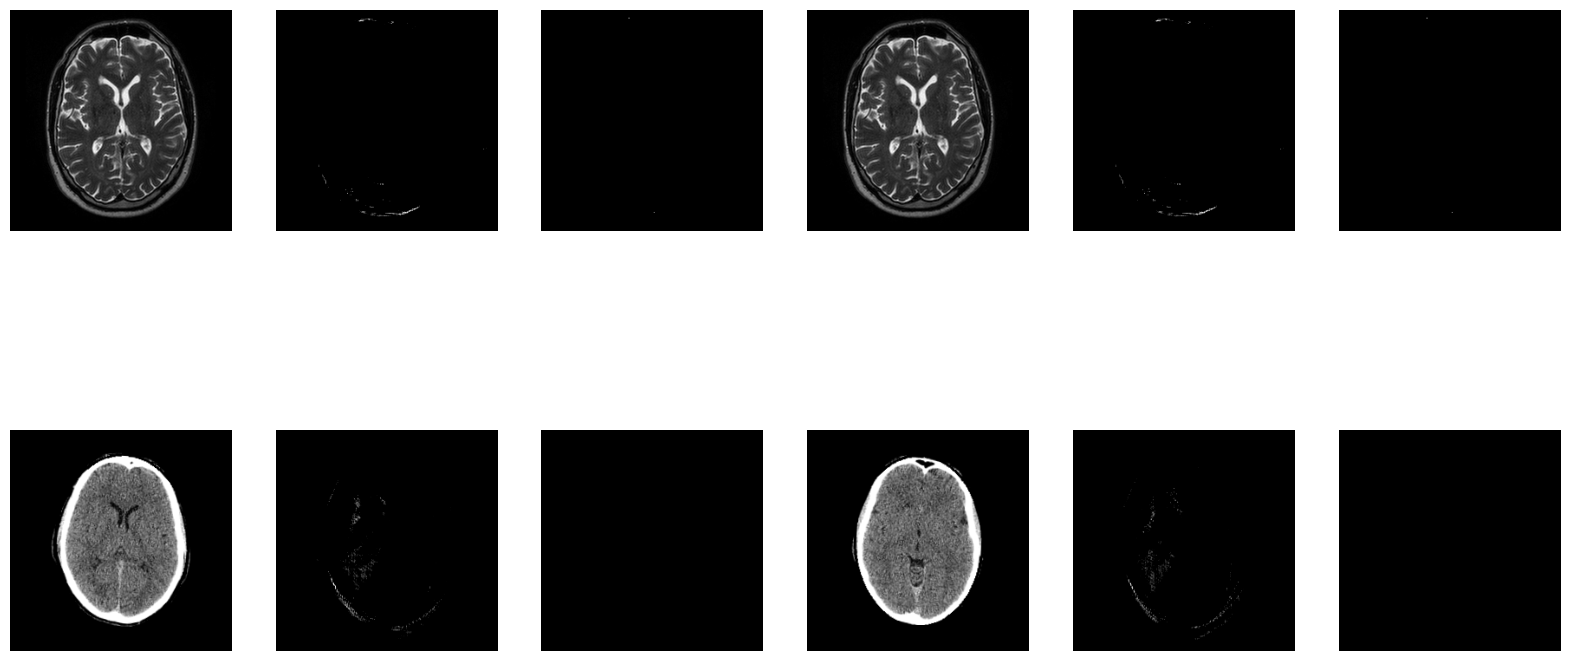

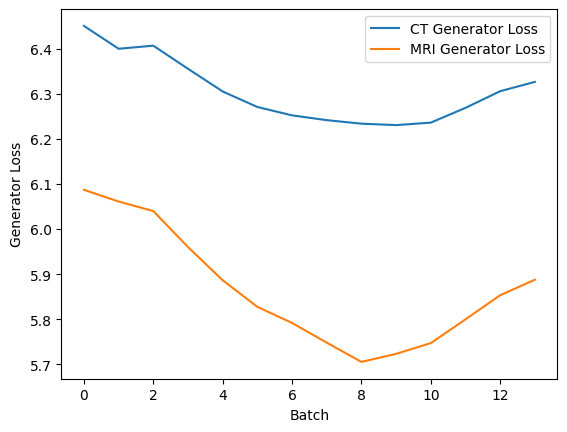

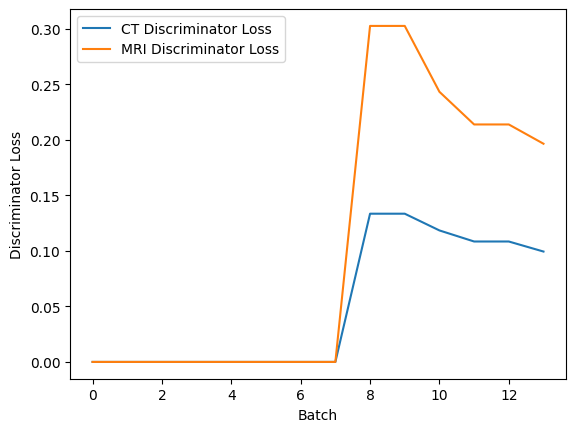

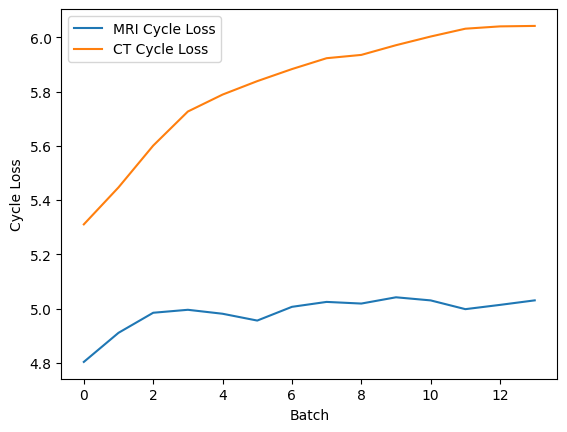

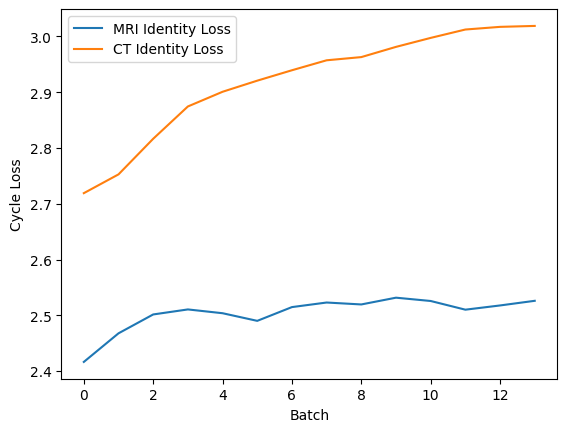

Epoch 6: 100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


<Figure size 640x480 with 0 Axes>

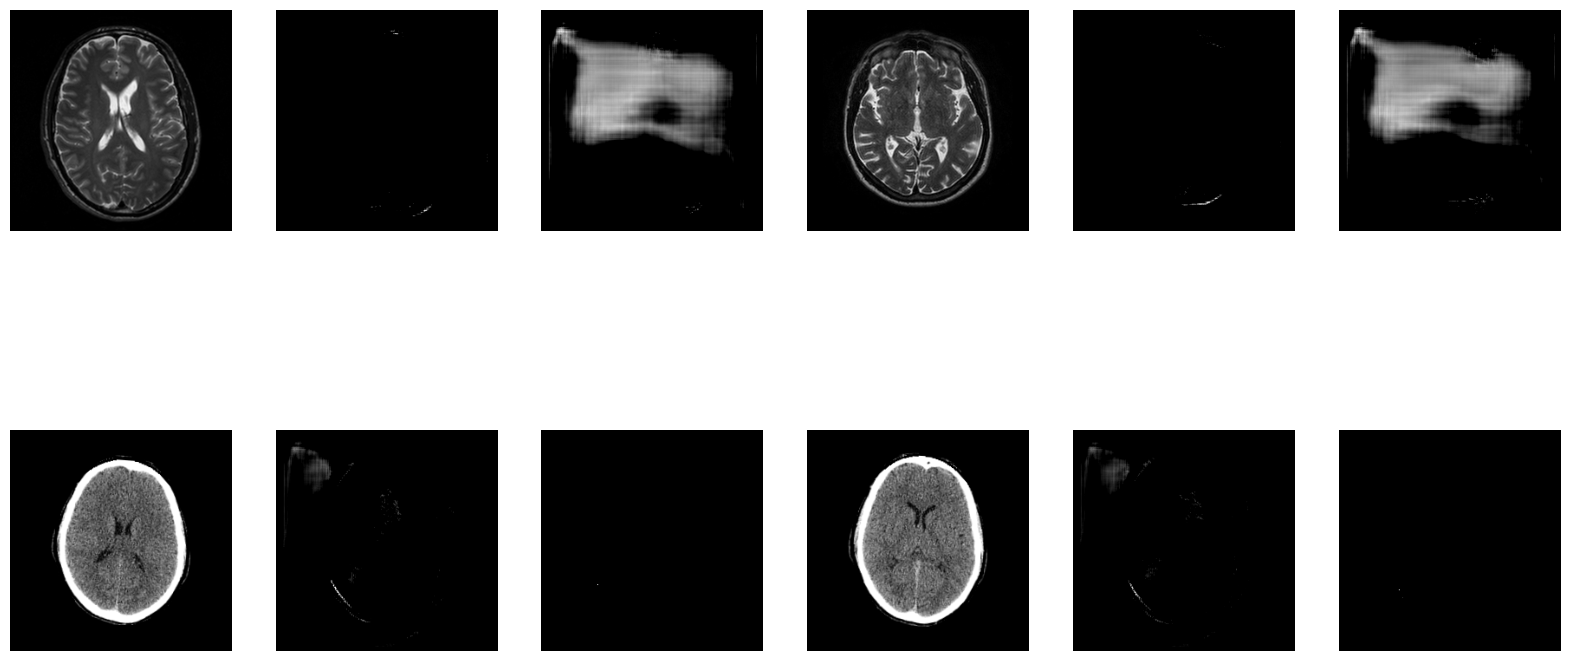

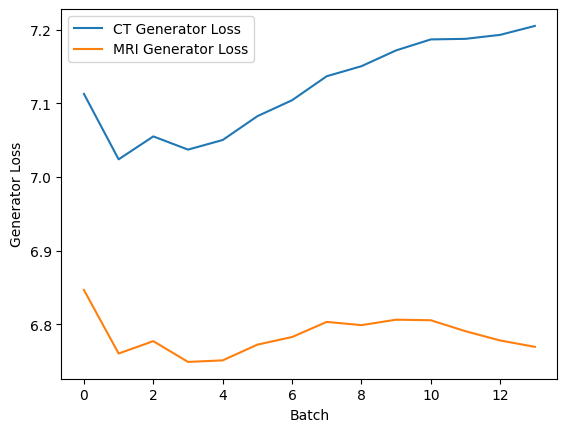

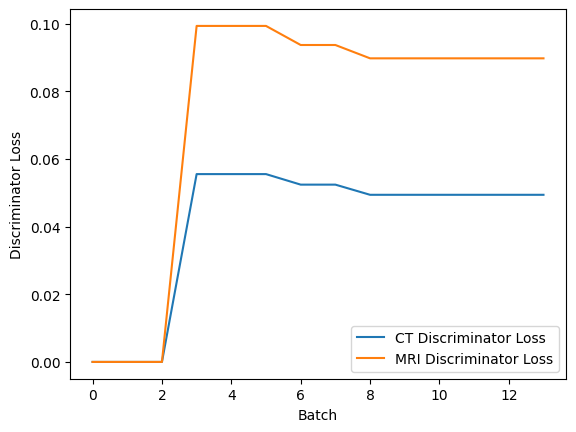

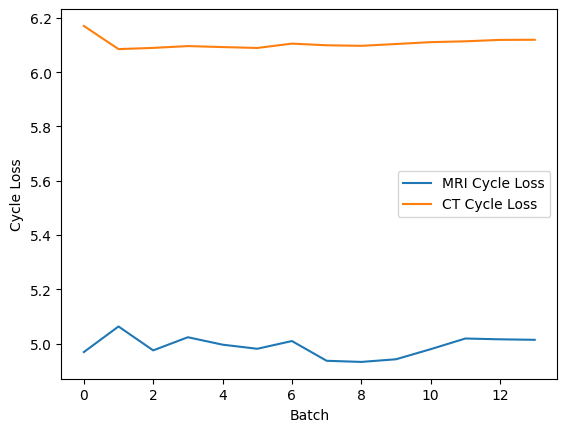

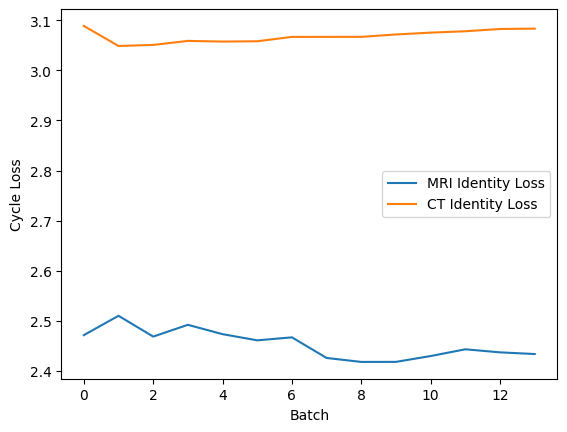

Epoch 8: 100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


<Figure size 640x480 with 0 Axes>

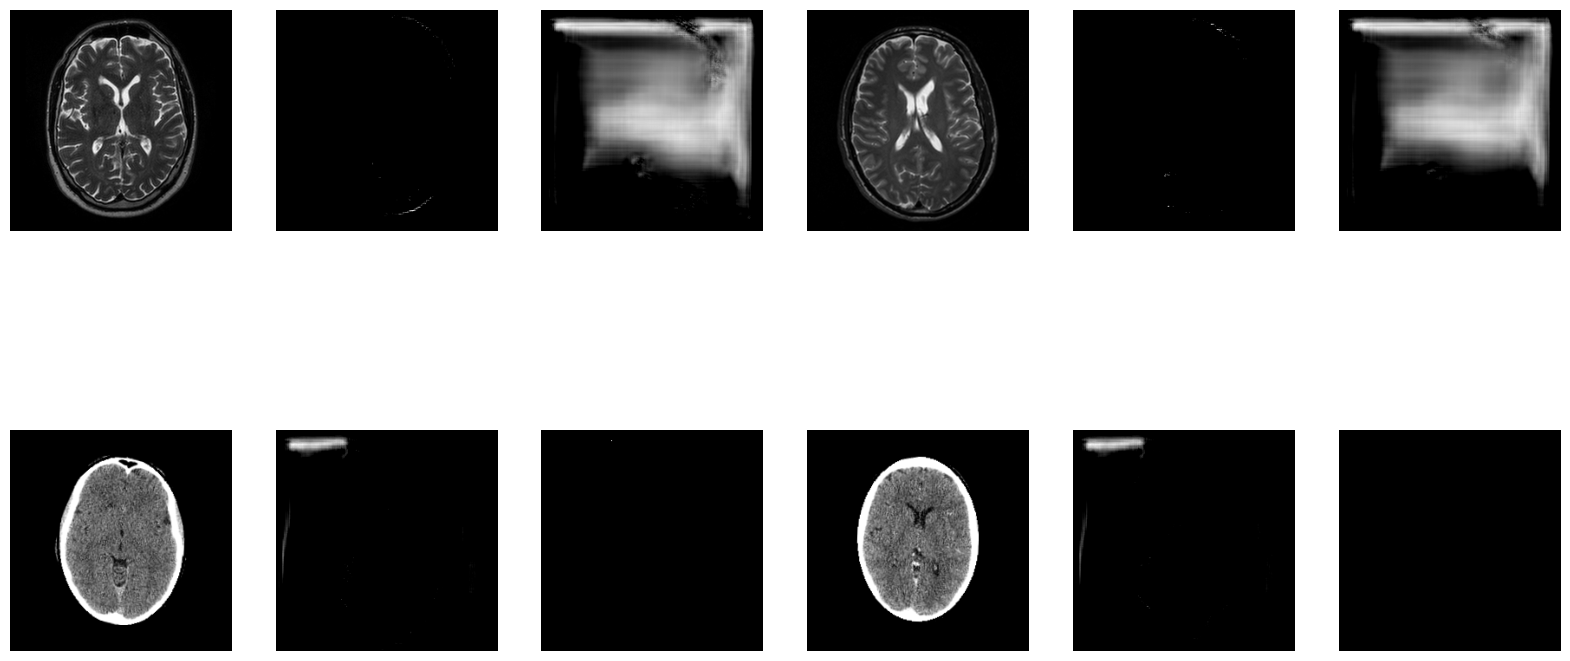

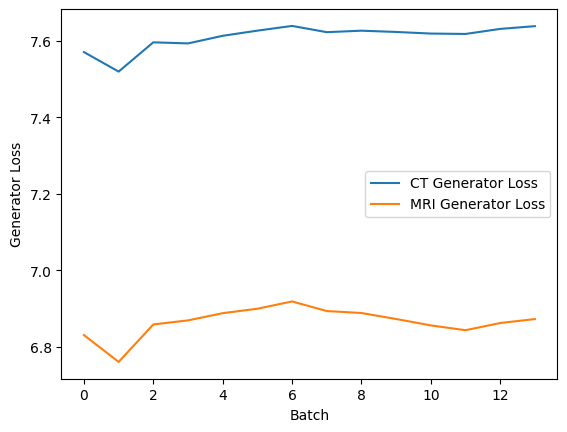

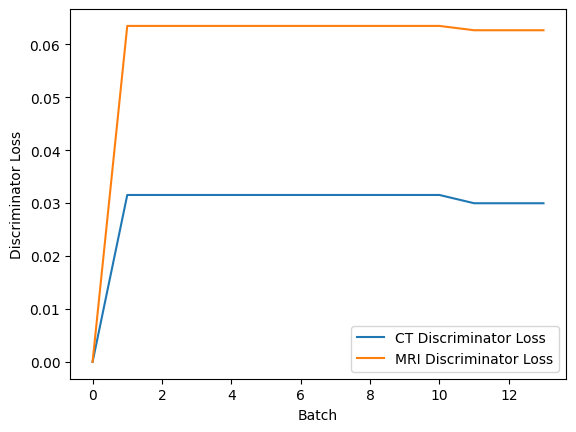

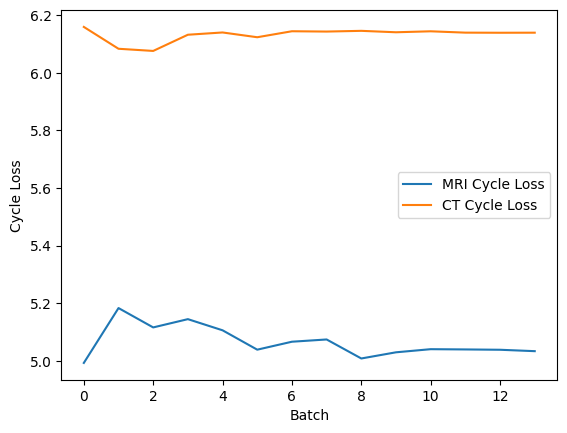

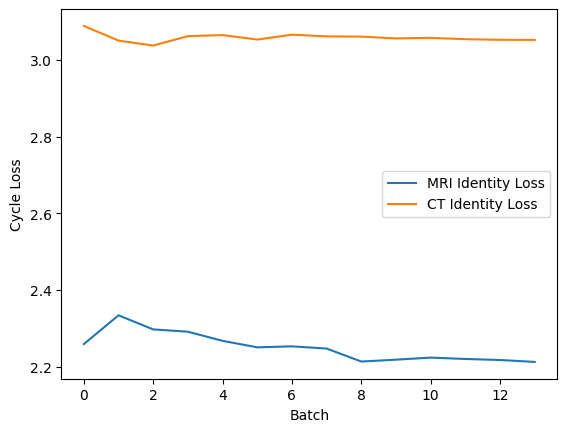

Epoch 9: 100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


In [18]:
losses = train(model, 
            CT_gen_opt, 
            CT_disc_opt, 
            MRI_gen_opt,
            MRI_disc_opt, 
            loss_discriminator, 
            loss_cycle, 
            loss_perceptual,
            MRIDataset_train,
            CTDataset_train,
            MRIDataset_test,
            CTDataset_test,
            batchsize=BATCH_SIZE,
            num_epochs=NUM_EPOCHS, 
            disc_ratio = 6, 
            gen_ratio = 1, 
            lambda_cycle=LAMBDA_CYCLE, 
            lambda_identity=LAMBDA_IDENTITY)

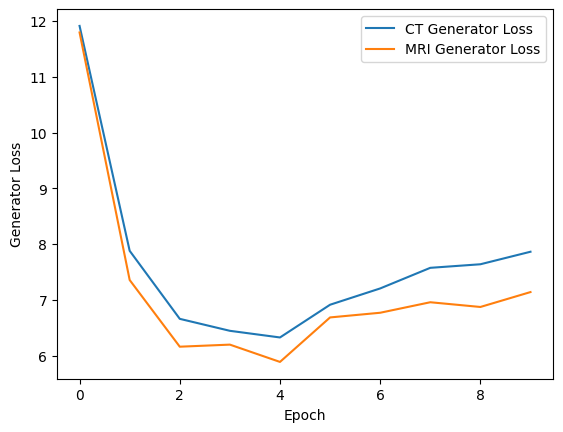

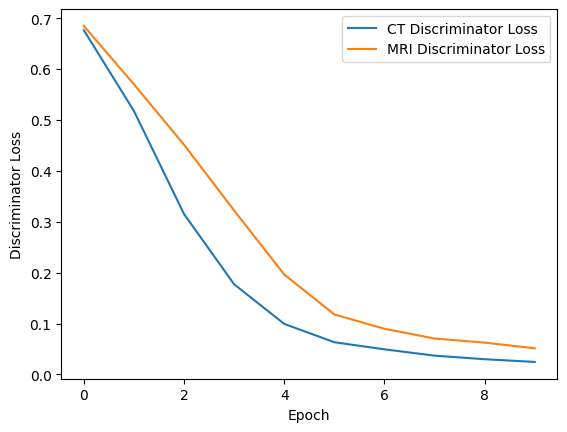

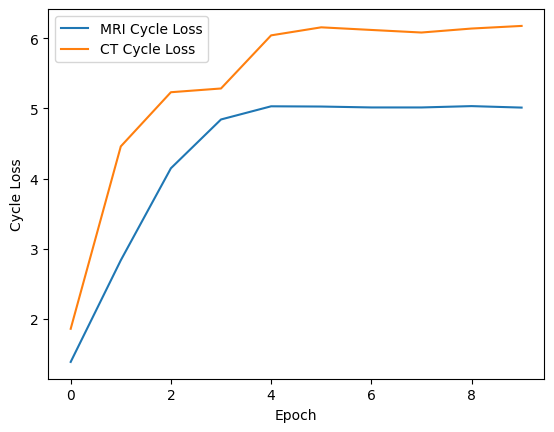

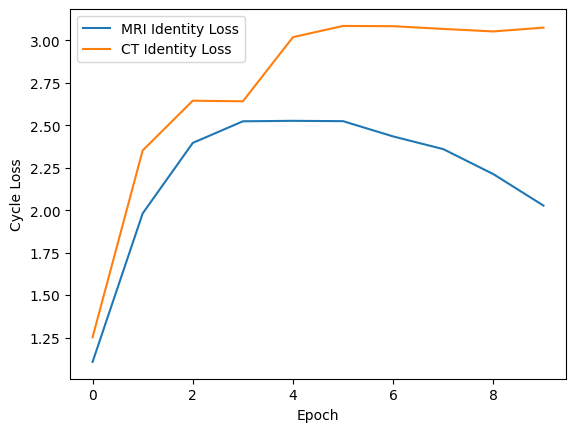

In [28]:
CT_Gens = [loss[0] for loss in losses]
CT_Discs = [loss[1] for loss in losses]
MRI_Gens = [loss[2] for loss in losses]
MRI_Discs = [loss[3] for loss in losses]
MRI_Cycles = [loss[4] for loss in losses]
CT_Cycles = [loss[5] for loss in losses]
MRI_Identity = [loss[6] for loss in losses]
CT_Identity = [loss[7] for loss in losses]
plt.plot(CT_Gens, label='CT Generator Loss')
plt.plot(MRI_Gens, label='MRI Generator Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.show()

plt.plot(CT_Discs, label='CT Discriminator Loss')
plt.plot(MRI_Discs, label='MRI Discriminator Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Discriminator Loss')
plt.show()

plt.plot(MRI_Cycles, label='MRI Cycle Loss')
plt.plot(CT_Cycles, label='CT Cycle Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cycle Loss')
plt.show()

plt.plot(MRI_Identity, label='MRI Identity Loss')
plt.plot(CT_Identity, label='CT Identity Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cycle Loss')
plt.show()

In [107]:
checkpoint = torch.load(f'checkpoints/epoch_190.pth.tar')
model.load_state_dict(checkpoint)

<All keys matched successfully>

# CT To MRI

31


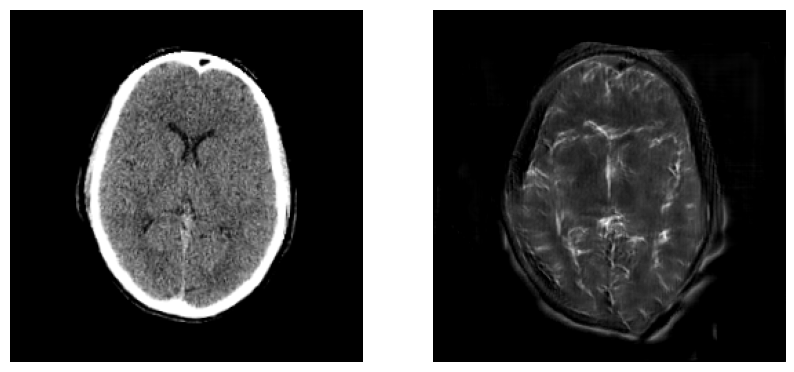

In [155]:
random_index = random.randint(0, len(CTDataset) - 1)
print(random_index)
generator_CT_MRI = model.generator_BA
with torch.no_grad(): 
  fake = generator_CT_MRI((CTDataset[random_index]).clone().detach().unsqueeze(0).float().to(DEVICE))

_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(CTDataset[random_index].squeeze().numpy(), cmap='gray')
ax[1].imshow(fake.squeeze().cpu().numpy(), cmap='gray')


# MRI To CT

28


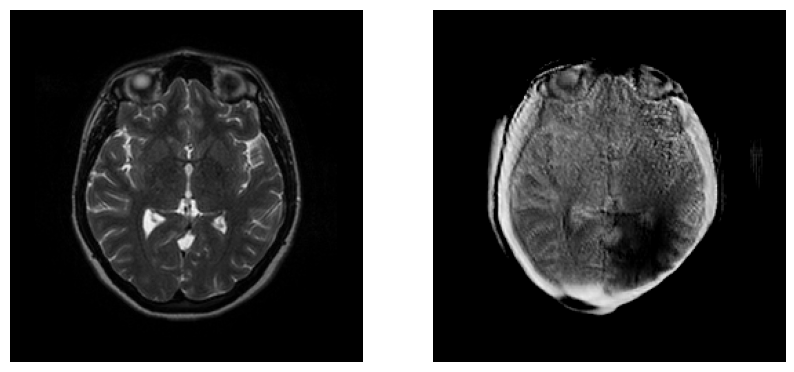

In [163]:
random_index = random.randint(0, len(MRIDataset) - 1)
print(random_index)
generator_MRI_CT = model.generator_AB
with torch.no_grad(): 
  fake = generator_MRI_CT((MRIDataset[random_index]).clone().detach().unsqueeze(0).float().to(DEVICE))

_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(MRIDataset[random_index].squeeze().numpy(), cmap='gray')
ax[1].imshow(fake.squeeze().cpu().numpy(), cmap='gray')

# FID Evaluation

In [23]:
block_idx = inception.InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = inception.InceptionV3([block_idx])
model=model.cuda()

# Calculate fid functions, modified from https://github.com/mseitzer/pytorch-fid
def calculate_activation_statistics(images,model,dims=2048):
    model = nn.Sequential(
        nn.Conv2d(1, 3, (2, 2), padding=2),
        model
    )
    model = model.cuda()
    model.eval()
    act=np.empty((len(images), dims))
    batch=images.cuda()
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = nn.adaptive_avg_pool2d(pred, output_size=(1, 1))
    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    tr_covmean = np.trace(covmean)
    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model)
     mu_2,std_2=calculate_activation_statistics(images_fake,model)
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

In [ ]:
MRISubset = Subset(MRIDataset, range(50))
CTSubset = Subset(CTDataset, range(50))
MRILoader_test = torch.utils.data.DataLoader(MRIDataset_test, batch_size=BATCH_SIZE, shuffle=True)
CTLoader_test = torch.utils.data.DataLoader(CTDataset_test, batch_size=BATCH_SIZE, shuffle=True)
batches_len = min(len(MRILoader_test), len(CTLoader_train))
generator_CT_MRI = model.generator_AB
generator_MRI_CT = model.generator_BA

t_batches = tqdm(zip(MRILoader_test, CTLoader_test), f'FID', total=batches_len)
MRI_FIDs = []
CT_FIDs = []
for batch_count, (real_MRI, real_CT) in enumerate(t_batches):
    real_MRI = real_MRI.to(DEVICE).float()
    real_CT = real_CT.to(DEVICE).float()

    with torch.no_grad(): 
        fake_MRI = generator_CT_MRI(real_CT)
        fake_MRI = fake_MRI.to(DEVICE).float()
        MRI_FID = calculate_fretchet(real_MRI, fake_MRI, model)
        MRI_FIDs.append(MRI_FID)

        fake_CT = generator_MRI_CT(real_MRI)
        fake_CT = fake_CT.to(DEVICE).float()
        CT_FID = calculate_fretchet(real_CT, fake_CT, model)
        CT_FIDs.append(CT_FID)

    t_batches.set_postfix(MRI_FID = MRI_FID, CT_FID = CT_FID)

In [ ]:
MRI_avg = np.mean(MRI_FIDs)
CT_avg = np.mean(CT_FIDs)
MRI_min = np.min(MRI_FIDs)
CT_min = np.min(CT_FIDs)
MRI_avg = MRI_min
CT_avg = CT_min

In [ ]:
print(MRI_avg)
print(CT_avg)